# Radar-lidar comparison using MAAP and PLAnT

_NASA-ESA Face-to-Face Meeting Demo - 6 December 2018_  

The UAVSAR radar and LVIS lidar instruments flew in 2016 over the Lope National Park, Gabon, during the joint NASA-ESA AfriSAR campaign. This exercise shows a first-order analysis of the L-band backscatter variation versus LVIS-derived mean canopy height using the PLAnT and MAAP tools. This sample notebook is for _demonstration purposes only_ of the PLAnT and MAAP tools. Processing, program interface and overall workflow are notional and will be updated in following versions of this notebook. After each PLAnT Python instruction below the equivalent shell command-line string is shown. Documentation is available by typing `plant_<command>.py --help` at command line.

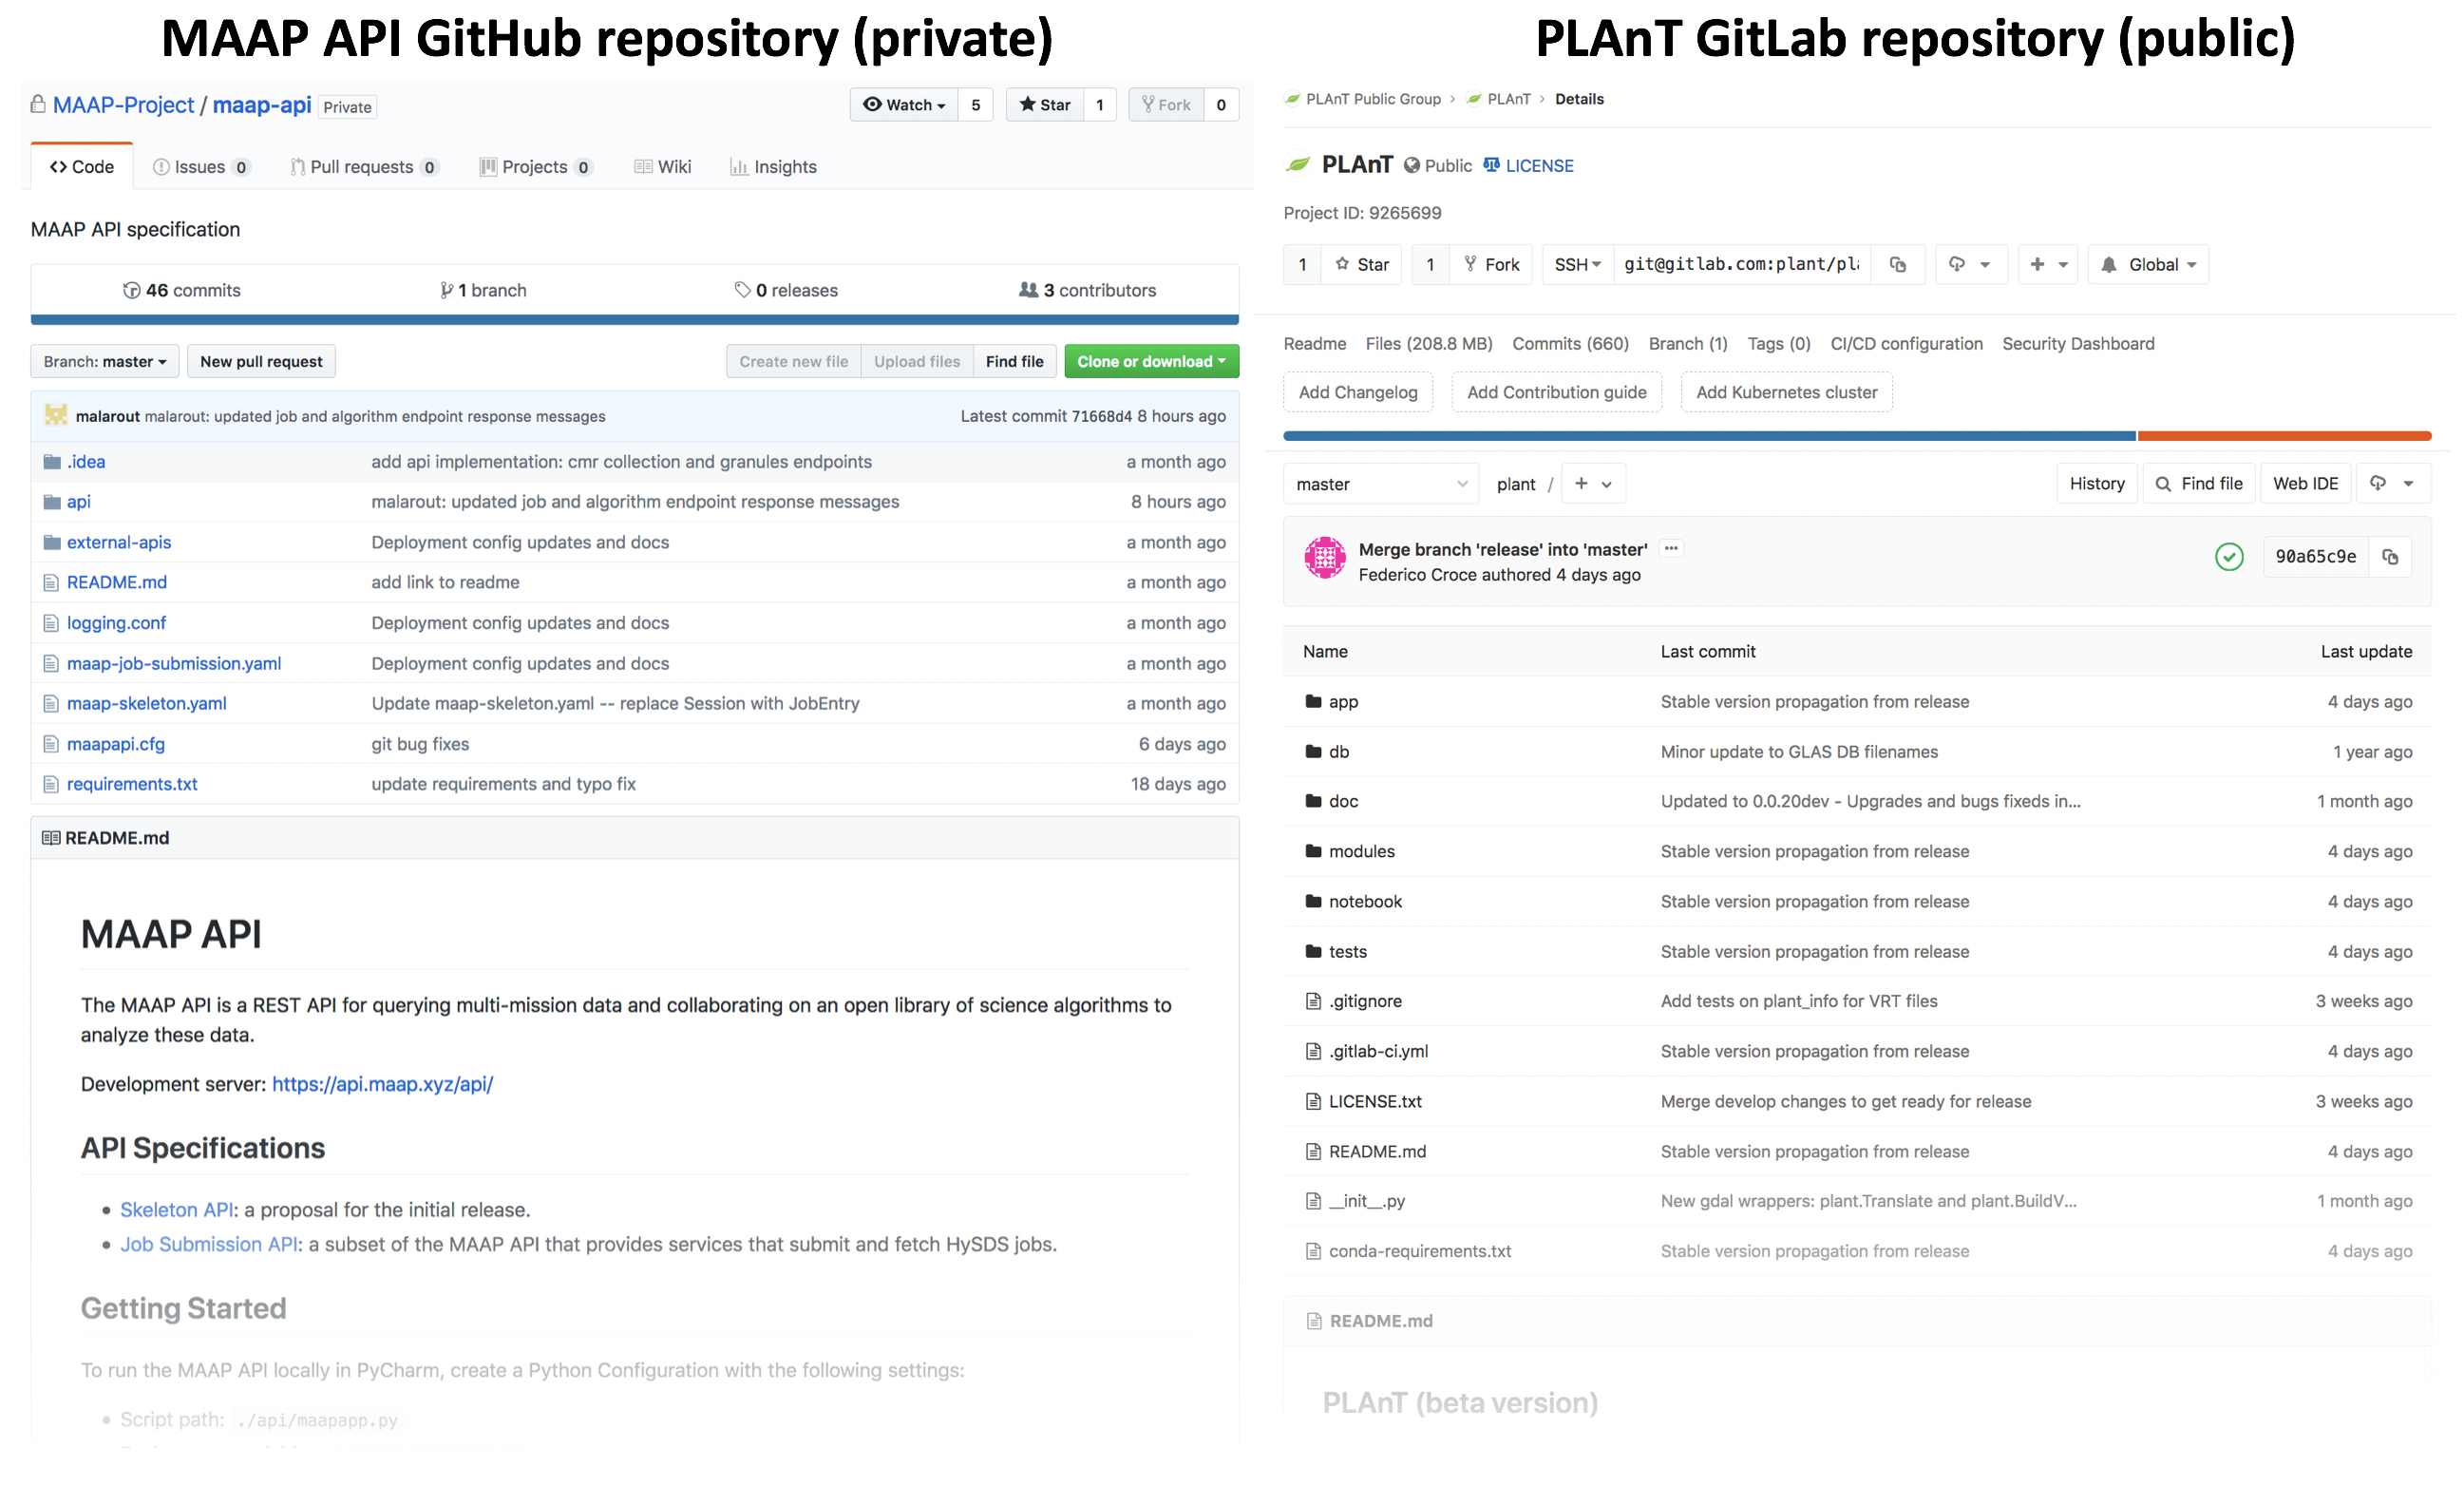

### Notebook workflow

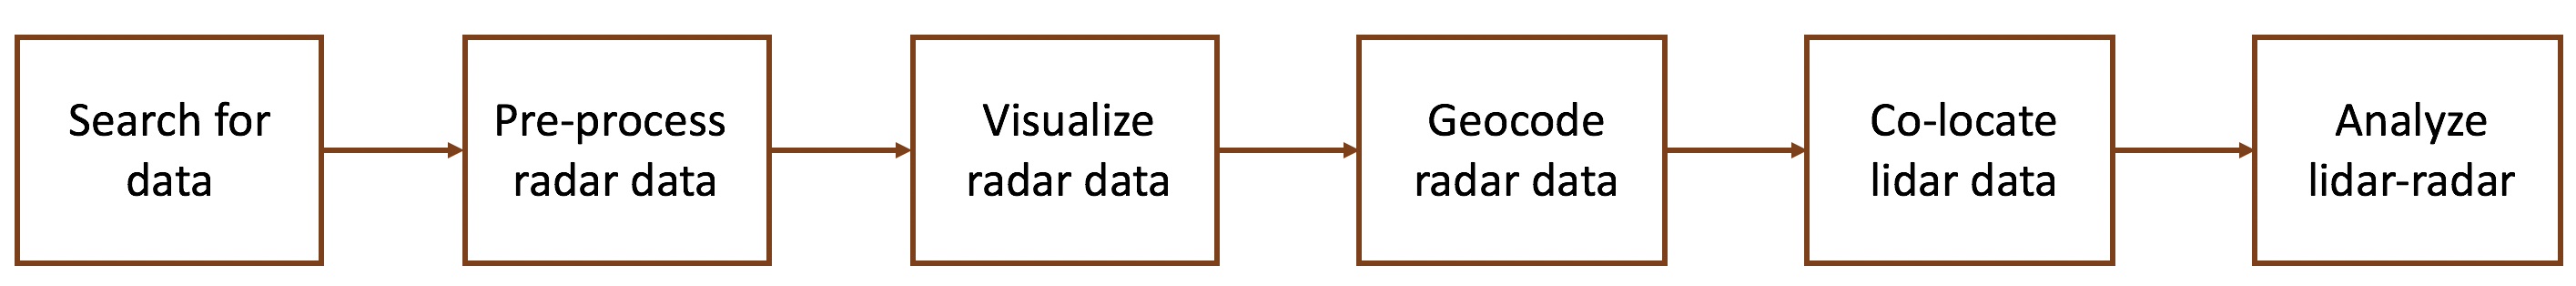

### 1. Prepare working environmentImport the Python packages needed in the workflow:

In [47]:
import sys
sys.path.append('../')

import plant
import maap
import os
import numpy as np
from osgeo import gdal
from maap.maap import MAAP
import jwt
import datetime
import multiprocessing

Initialize the MAAP API

In [48]:
app_auth_key = 'xxx' # from maap-api/api/settings.py
token = jwt.encode({
  'user': 'beta-user',
  'exp': datetime.datetime.utcnow() + datetime.timedelta(weeks=24)
}, app_auth_key)
maapConfig = '../maap-py/maap.cfg'
maap = MAAP(maapConfig, token = token) 
LOCAL_PATH = '/home/ubuntu'

../maap-py/maap.cfg


## 2. Search for data within MAAP

Set up the main variables such as input data and output folder: 

In [49]:
# Radar data
pool = multiprocessing.Pool(4)

# Radar data
radarGranules = maap.searchGranule(instrument='UAVSAR', track_number='001')
async_results = [ pool.apply_async(i.getLocalPath, (i,)) for i in radarGranules ]
pool.close()

In [51]:
# Rdr files
pool = multiprocessing.Pool(4)

rdrFiles = maap.searchGranule(instrument='UAVSAR', data_format='rdr')
async_results = [ pool.apply_async(i.getLocalPath, (i,)) for i in rdrFiles ]
pool.close()

In [52]:
import copy

# hdrFiles
hdrFiles = copy.deepcopy(rdrFiles)
for f in hdrFiles:
    f._location = f._location + '.hdr'

hdrFiles[0]._location
pool = multiprocessing.Pool(4)
async_results = [ pool.apply_async(i.getLocalPath, (i,)) for i in hdrFiles ]
pool.close()

In [53]:
radarGranule = list(filter(lambda granule: granule._location.endswith('.vrt'), radarGranules))[0]
radarData = radarGranule.getLocalPath()
_ = plant.info(radarData)

PLAnT 0.0.29dev (function call) - plant_info.py -i "/code/notebooks/uavsar_AfriSAR_v1_SLC-lopenp_14043_16015_001_160308_L090.vrt" -o "MEM:output.bin"
PLAnT 0.0.29dev - plant_info.py -i "/code/notebooks/uavsar_AfriSAR_v1_SLC-lopenp_14043_16015_001_160308_L090.vrt" -o "MEM:output.bin"
file: /code/notebooks/uavsar_AfriSAR_v1_SLC-lopenp_14043_16015_001_160308_L090.vrt
    file format: VRT
    length: 85380
    width: 9900
    number of elements: 845262000
    number of bands: 4
    data type: complex64


In [54]:
# Topo data including lat/lon layers, topography, sim. amplitude, etc.
topoGranule = maap.searchGranule(granule_ur='uavsar_AfriSAR_v1_SLC-topo')
topoData = topoGranule[0].getLocalPath().replace('//', '/')
print("Found topo data:", topoData)

Found topo data: /code/notebooks/uavsar_AfriSAR_v1_SLC-topo.vrt


In [55]:
# Output folder and filename
workingDir = LOCAL_PATH + '/maap_demo/notebook_output_demo'
croppedRadarData = os.path.join(workingDir, 'lope_afrisar_cropped.vrt')
croppedTopoData  = os.path.join(workingDir, 'topo_cropped.vrt')
os.makedirs(workingDir, exist_ok=True)

In [90]:
# Lidar data
pool = multiprocessing.Pool(4)

lvisL2Granules = maap.searchGranule(instrument='lvis', data_format="ascii", site_name='Lope')
async_results = [ pool.apply_async(i.getLocalPath, (i,)) for i in lvisL2Granules ]
pool.close()

**Check files are downloaded with `!ls`**

### 3. Pre-process radar data
Query the size of the input dataset using `plant_info`:

In [60]:
_ = plant.info(radarData)

PLAnT 0.0.29dev (function call) - plant_info.py -i "/code/notebooks/uavsar_AfriSAR_v1_SLC-lopenp_14043_16015_001_160308_L090.vrt" -o "MEM:output.bin"
PLAnT 0.0.29dev - plant_info.py -i "/code/notebooks/uavsar_AfriSAR_v1_SLC-lopenp_14043_16015_001_160308_L090.vrt" -o "MEM:output.bin"
file: /code/notebooks/uavsar_AfriSAR_v1_SLC-lopenp_14043_16015_001_160308_L090.vrt
    file format: VRT
    length: 85380
    width: 9900
    number of elements: 845262000
    number of bands: 4
    data type: complex64


Subset the input radar data with lines and columns (lat/lon also possible) using `plant_util` or `plant_crop`:

In [61]:
srcWin = [1200, 41000, 450, 3550] # x0,y0, width, height

_ = plant.util(radarData, 
               output=croppedRadarData, 
               srcwin=srcWin, 
               band=2, 
               force=True,
               mute=True)

_ = plant.util(topoData, 
               output=croppedTopoData, 
               srcwin=srcWin, 
               force=True, 
               mute=True)

PLAnT 0.0.29dev (function call) - plant_util.py -i "/code/notebooks/uavsar_AfriSAR_v1_SLC-lopenp_14043_16015_001_160308_L090.vrt" -w "1200" "41000" "450" "3550" --band "2" -f --mute -o "/home/ubuntu/maap_demo/notebook_output_demo/lope_afrisar_cropped.vrt"
PLAnT 0.0.29dev (function call) - plant_util.py -i "/code/notebooks/uavsar_AfriSAR_v1_SLC-topo.vrt" -w "1200" "41000" "450" "3550" -f --mute -o "/home/ubuntu/maap_demo/notebook_output_demo/topo_cropped.vrt"


Verify that cropped radat data have the correct size corresponding to `srcWin` parameters defined above:

In [62]:
_ = plant.info(croppedRadarData)

PLAnT 0.0.29dev (function call) - plant_info.py -i "/home/ubuntu/maap_demo/notebook_output_demo/lope_afrisar_cropped.vrt" -o "MEM:output.bin"
PLAnT 0.0.29dev - plant_info.py -i "/home/ubuntu/maap_demo/notebook_output_demo/lope_afrisar_cropped.vrt" -o "MEM:output.bin"
file: /home/ubuntu/maap_demo/notebook_output_demo/lope_afrisar_cropped.vrt
    file format: VRT
    length: 3550
    width: 450
    number of elements: 1597500
    number of bands: 1
    data type: complex64


Multi-look radar data using `plant_filter`. Selected multi-look factors allow sufficient independent looks to reduce speckle and give a sample size on the ground of approximately 17 m along azimuth.

In [63]:
# Define multi-look factors
nlooksAzimuth = 29
nlooksRange = 5

radarDirMLK  = os.path.join(workingDir, f'covdir_r{nlooksRange}_a{nlooksAzimuth}')
radarFileMLK ='topo_mlk.bin'
mlkRadarData = os.path.join(radarDirMLK, radarFileMLK)

# Multi-look
result = plant.filter(croppedRadarData, 
                      output_dir=radarDirMLK, 
                      transform_square=True, 
                      force=True,
                      nlooks=[nlooksAzimuth, nlooksRange], 
                      separate=True, 
                      output_file=radarFileMLK, 
                      output_format='ENVI', 
                      mute=True)

PLAnT 0.0.29dev (function call) - plant_filter.py -i "/home/ubuntu/maap_demo/notebook_output_demo/lope_afrisar_cropped.vrt" --od "/home/ubuntu/maap_demo/notebook_output_demo/covdir_r5_a29" --square -f --ml "29" "5" --separate --of "ENVI" --mute -o "topo_mlk.bin"


Multi-look topo layers used below for resampling. Topo layers could be re-generated by importing `isce`. Use multi-look here for simplicity.

In [64]:
# Define output folder
topoDirMLK  = os.path.join(workingDir, f'topo_r{nlooksRange}_a{nlooksAzimuth}')
topoFileMLK ='topo_mlk.bin'
mlkTopoData = os.path.join(topoDirMLK, topoFileMLK)

# Multi-looking
result = plant.filter(croppedTopoData, 
                      output_dir=topoDirMLK, 
                      #band="5,6",
                      force=True,
                      nlooks=[nlooksAzimuth, nlooksRange], 
                      separate=True, 
                      output_file=topoFileMLK, 
                      output_format='ENVI', 
                      mute=True)

PLAnT 0.0.29dev (function call) - plant_filter.py -i "/home/ubuntu/maap_demo/notebook_output_demo/topo_cropped.vrt" --od "/home/ubuntu/maap_demo/notebook_output_demo/topo_r5_a29" -f --ml "29" "5" --separate --of "ENVI" --mute -o "topo_mlk.bin"


Verify that number of lines and columns changed after multi-looking:

In [66]:
_ = plant.info(mlkRadarData)

PLAnT 0.0.29dev (function call) - plant_info.py -i "/home/ubuntu/maap_demo/notebook_output_demo/covdir_r5_a29/topo_mlk.bin" -o "MEM:output.bin"
PLAnT 0.0.29dev - plant_info.py -i "/home/ubuntu/maap_demo/notebook_output_demo/covdir_r5_a29/topo_mlk.bin" -o "MEM:output.bin"
file: /home/ubuntu/maap_demo/notebook_output_demo/covdir_r5_a29/topo_mlk.bin
    header file: /home/ubuntu/maap_demo/notebook_output_demo/covdir_r5_a29/topo_mlk.hdr
    file format: ENVI
    scheme: bsq
    length: 123
    width: 90
    number of elements: 11070
    metadata Band_1: Band 1
    number of bands: 1
    data type: float64


## 4. Visualize radar data
Use `plant_display` to visualize radar backscatter and the local radar incidence  (band 5).

PLAnT 0.0.29dev (function call) - plant_display.py "/home/ubuntu/maap_demo/notebook_output_demo/covdir_r5_a29/topo_mlk.bin" --label-colorbar "Radar Backscatter [dB]" --title "" --mute --db


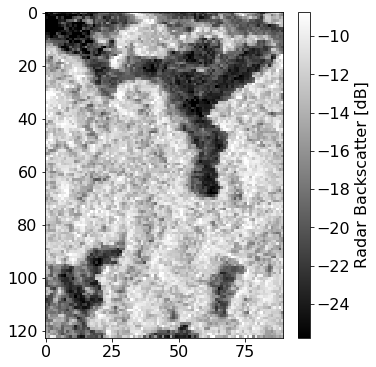

In [67]:
%matplotlib inline
_ = plant.display(mlkRadarData, 
                  label_colorbar='Radar Backscatter [dB]',
                  title='',
                  mute=True, dB=True)

PLAnT 0.0.29dev (function call) - plant_display.py "/home/ubuntu/maap_demo/notebook_output_demo/topo_r5_a29/topo_mlk.bin" --mute --band "5" --no-im-rgb --title "Local Incidence Angle [deg]"


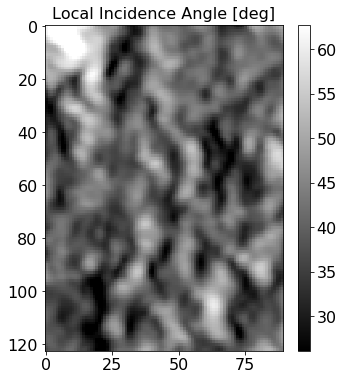

In [68]:
_ = plant.display(mlkTopoData, 
                  mute=True, 
                  band=5,
                  no_rgb=False, title='Local Incidence Angle [deg]')

## 5. Geocode radar data
Using the topo layers and `plant_mosaic` (wrapper for `gdalwarp`) project data on a lat/lon grid. Then display the data. Border artifacts are temporarily removed.

In [69]:
geoRadarData = os.path.join(workingDir+'/geo/', 'lopegeo_mlk.tif')

_ = plant.mosaic(mlkRadarData,
                 t=mlkTopoData, 
                 o=geoRadarData, 
                 force=True, 
                 mute=True,
                 interp='bilinear',
                 debug=False)

PLAnT 0.0.29dev (function call) - plant_mosaic.py -i "/home/ubuntu/maap_demo/notebook_output_demo/covdir_r5_a29/topo_mlk.bin" -t "/home/ubuntu/maap_demo/notebook_output_demo/topo_r5_a29/topo_mlk.bin" -f --mute --interp "bilinear" -o "/home/ubuntu/maap_demo/notebook_output_demo/geo/lopegeo_mlk.tif"


PLAnT 0.0.29dev (function call) - plant_display.py "/home/ubuntu/maap_demo/notebook_output_demo/geo/lopegeo_mlk.tif" --mute --label-colorbar "Radar Backscatter [dB]" --db --mask-erode "6" --bg "white" --title "" --cmap "jet"


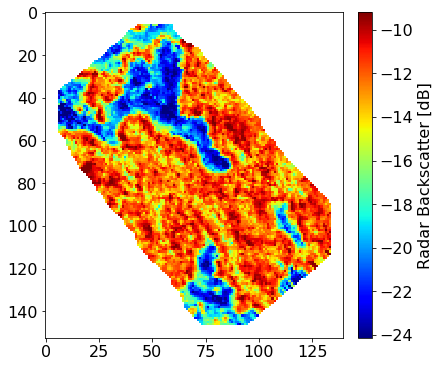

In [70]:
_ = plant.display(geoRadarData,
                  mute=True,
                  label_colorbar='Radar Backscatter [dB]',
                  dB=True, 
                  mask_erode=6,
                  background='white',
                  title='',
                  cmap='jet')

## 6. Prepare lidar data
Resample lidar samples using the radar data as reference to calculate geographic region extent and pixel spacing with `plant_csv_reader` (wrapper around `gdalgrid`). Other choices of lidar metric and resampling algorithms are possible.  

In [93]:
# Define output lvis files
lvisL2Files = os.path.join('./*TXT')

In [94]:
# WARNING: This takes a few minutes to run
lidarFileZg = os.path.join(workingDir, 'zg_20.bin')
lidarFileZt = os.path.join(workingDir, 'zt_20.bin')

# Calculate footprint in decimal degrees
footprint = np.mean(plant.m_to_deg(18.25, lat=-0.8))

# Select lvis top-canopy. Other choices are possible
zg_obj = plant.csv_reader(lvisL2Files, 
                          output_file=lidarFileZg, 
                          bbox_file=geoRadarData, 
                          #step_m=20, 
                          footprint=footprint, 
                          lon_text='GLON', lat_text='GLAT', 
                          data_text_list='ZG', 
                          force=True, output_skip_if_existent=False, 
                          lvis=True, save_as_raster_gdal=True,
                          mute=True)

zt_obj = plant.csv_reader(lvisL2Files, 
                          output_file=lidarFileZt, 
                          bbox_file=geoRadarData, 
                          #step_m=20,
                          footprint=footprint, 
                          lon_text='TLON', lat_text='TLAT', 
                          data_text_list='ZT', 
                          force=True, output_skip_if_existent=False,
                          lvis=True, save_as_raster_gdal=True,
                          mute=True) 

PLAnT 0.0.29dev (function call) - plant_csv_reader.py -i "./ILVIS2_GA2016_0302_R1610_057582.TXT" "./ILVIS2_GA2016_0302_R1610_060655.TXT" "./ILVIS2_GA2016_0302_R1610_061654.TXT" "./ILVIS2_GA2016_0302_R1610_065695.TXT" "./ILVIS2_GA2016_0302_R1610_063295.TXT" "./ILVIS2_GA2016_0302_R1610_063699.TXT" "./ILVIS2_GA2016_0302_R1610_056408.TXT" "./ILVIS2_GA2016_0302_R1610_062682.TXT" "./ILVIS2_GA2016_0302_R1610_058600.TXT" "./ILVIS2_GA2016_0302_R1610_055488.TXT" "./ILVIS2_GA2016_0302_R1610_055987.TXT" "./ILVIS2_GA2016_0302_R1610_059646.TXT" "./ILVIS2_GA2016_0302_R1610_064622.TXT" "./ILVIS2_GA2016_0302_R1610_059019.TXT" "./ILVIS2_GA2016_0302_R1610_061248.TXT" "./ILVIS2_GA2016_0302_R1610_062278.TXT" "./ILVIS2_GA2016_0302_R1610_056989.TXT" "./ILVIS2_GA2016_0302_R1610_060055.TXT" "./ILVIS2_GA2016_0302_R1610_065027.TXT" "./ILVIS2_GA2016_0302_R1610_058029.TXT" -g "/home/ubuntu/maap_demo/notebook_output_demo/geo/lopegeo_mlk.tif" --footprint "0.0001639505303614645" --lon-label "GLON" --lat-label "GLAT" 

In [95]:
lidarFileZt_m_Zg = os.path.join(workingDir, 'zt_m_zg_20.bin')

_ = plant.util(lidarFileZt, 
               lidarFileZg, 
               diff=True, 
               o=lidarFileZt_m_Zg, 
               force=True, mute=True)

PLAnT 0.0.29dev (function call) - plant_util.py -i "/home/ubuntu/maap_demo/notebook_output_demo/zt_20.bin" "/home/ubuntu/maap_demo/notebook_output_demo/zg_20.bin" --diff -f --mute -o "/home/ubuntu/maap_demo/notebook_output_demo/zt_m_zg_20.bin"


## 7. Display lidar and radar data

Display the histogram of the resampled lidar mean canopy height data:

PLAnT 0.0.29dev (function call) - plant_display.py "/home/ubuntu/maap_demo/notebook_output_demo/zt_m_zg_20.bin" --hist --title "" --labelx "LVIS top-canopy height [m]" --mute -c "orange"


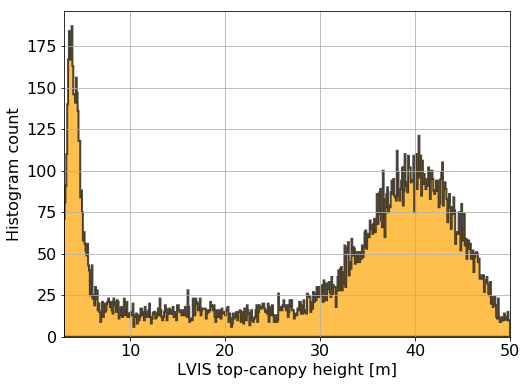

In [97]:
_ = plant.display(lidarFileZt_m_Zg, 
                  hist=True, 
                  title='', 
                  x_label='LVIS top-canopy height [m]',
                  mute=True,
                  color='orange')

Visualize lidar-derived mean canopy height: 

PLAnT 0.0.29dev (function call) - plant_display.py "/home/ubuntu/maap_demo/notebook_output_demo/zt_m_zg_20.bin" --mute --label-colorbar "LVIS top-canopy height [m]" --title "" --cmap "YlGn"


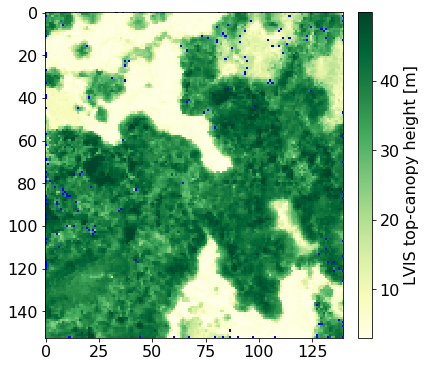

In [99]:
_ = plant.display(lidarFileZt_m_Zg,
                  mute=True,
                  label_colorbar='LVIS top-canopy height [m]',
                  title='',
                  cmap='YlGn')

Display binned backscatter in dB versus lidar-derived top-canopy height data. For fun, fit a 3-order polynomial to illustrate the capabilities of `plant_display`. The program supports several other options and fitting parameters. 

PLAnT 0.0.29dev (function call) - plant_util.py -i "/home/ubuntu/maap_demo/notebook_output_demo/geo/lopegeo_mlk.tif" --db -f --mute -o "/home/ubuntu/maap_demo/notebook_output_demo/geo/lopegeo_db.bin"
PLAnT 0.0.29dev (function call) - plant_display.py "/home/ubuntu/maap_demo/notebook_output_demo/zt_m_zg_20.bin" "/home/ubuntu/maap_demo/notebook_output_demo/geo/lopegeo_db.bin" --trendplot --mute --mask-equal "0" --fit "3" --labelx "LVIS top-canopy height [m]" --labely "Radar Backscatter [dB]" --title ""
PLAnT 0.0.29dev - plant_display.py "/home/ubuntu/maap_demo/notebook_output_demo/zt_m_zg_20.bin" "/home/ubuntu/maap_demo/notebook_output_demo/geo/lopegeo_db.bin" --trendplot --mute --mask-equal "0" --fit "3" --labelx "LVIS top-canopy height [m]" --labely "Radar Backscatter [dB]" --title ""
input 1: /home/ubuntu/maap_demo/notebook_output_demo/zt_m_zg_20.bin (band: 0)
    arguments: /home/ubuntu/maap_demo/notebook_output_demo/zt_m_zg_20.bin
    format: GTiff
    dtype: float32
opening: /home/

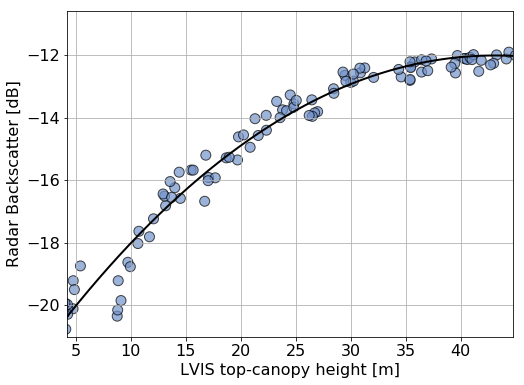

In [100]:
# Transform radar backscatter to dB
geoRadarDataDB=os.path.join(workingDir+'/geo/', 'lopegeo_db.bin')

_ = plant.util(geoRadarData, 
               dB=True, 
               o=geoRadarDataDB,
               force=True, mute=True)

# Display backscatter in dB with lidar-derived 
_ = plant.display(lidarFileZt_m_Zg,
                  os.path.join(workingDir+'/geo/', 'lopegeo_db.bin'),
                  trendplot=True,
                  mute=True,
                  mask_equal=0,
                  fit=3,
                  x_label="LVIS top-canopy height [m]",
                  y_label="Radar Backscatter [dB]",
                  title='')